In [1]:
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

import mediapipe as mp

### choose dataset by commenting/uncommenting

# # DDD dataset
# path = '/home/dimoik/Downloads/data/DDD/'
# suffix = 'ddd'

# nthuddd2 dataset
path = '/home/dimoik/Downloads/data/nthuddd2/'
suffix = 'nthu'

In [2]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.3, min_tracking_confidence=0.8)
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

I0000 00:00:1702686783.474009   15156 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702686783.477240   15205 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: RENOIR (renoir, LLVM 15.0.7, DRM 3.49, 6.2.0-39-generic)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
right_eye = [[33, 133], [160, 144], [159, 145], [158, 153]] # right eye landmark positions
left_eye = [[263, 362], [387, 373], [386, 374], [385, 380]] # left eye landmark positions
mouth = [[61, 291], [39, 181], [0, 17], [269, 405]] # mouth landmark coordinates

In [4]:
def distance(p1, p2):
    return (((p1[:2] - p2[:2])**2).sum())**0.5

def eye_aspect_ratio(landmarks, eye):
    N1 = distance(landmarks[eye[1][0]], landmarks[eye[1][1]])
    N2 = distance(landmarks[eye[2][0]], landmarks[eye[2][1]])
    N3 = distance(landmarks[eye[3][0]], landmarks[eye[3][1]])
    D = distance(landmarks[eye[0][0]], landmarks[eye[0][1]])
    return (N1 + N2 + N3) / (3 * D)

def eye_feature(landmarks):
    return (eye_aspect_ratio(landmarks, left_eye) + eye_aspect_ratio(landmarks, right_eye))/2

def mouth_feature(landmarks):
    N1 = distance(landmarks[mouth[1][0]], landmarks[mouth[1][1]])
    N2 = distance(landmarks[mouth[2][0]], landmarks[mouth[2][1]])
    N3 = distance(landmarks[mouth[3][0]], landmarks[mouth[3][1]])
    D = distance(landmarks[mouth[0][0]], landmarks[mouth[0][1]])
    return (N1 + N2 + N3)/(3*D)

In [5]:
drowsy_feats = []
drowsy_list = os.listdir(path+"drowsy/")
print(len(drowsy_list))

for name in drowsy_list:
    image = cv2.imread(path+"drowsy/"+name)
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = face_mesh.process(image)
    
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if results.multi_face_landmarks:
        landmarks_positions = []
        # assume that only face is present in the image
        for _, data_point in enumerate(results.multi_face_landmarks[0].landmark):
            landmarks_positions.append([data_point.x, data_point.y, data_point.z]) # saving normalized landmark positions
        landmarks_positions = np.array(landmarks_positions)
        landmarks_positions[:, 0] *= image.shape[1]
        landmarks_positions[:, 1] *= image.shape[0]

        ear = eye_feature(landmarks_positions)
        mar = mouth_feature(landmarks_positions)
        drowsy_feats.append((ear, mar))
    else:
        continue

drowsy_feats = np.array(drowsy_feats)

with open("./feats/"+suffix+"_mp_drowsy_feats", "wb") as fp:
    pickle.dump(drowsy_feats, fp)

36030


In [7]:
with open("./feats/"+suffix+"_mp_drowsy_feats", "rb") as fp:
    drowsy_feats = pickle.load(fp)

In [8]:
non_drowsy_feats = []
non_drowsy_list = os.listdir(path+"notdrowsy/")
print(len(non_drowsy_list))

for name in non_drowsy_list:
    image = cv2.imread(path+"notdrowsy/"+name)
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = face_mesh.process(image)
    
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if results.multi_face_landmarks:
        landmarks_positions = []
        # assume that only face is present in the image
        for _, data_point in enumerate(results.multi_face_landmarks[0].landmark):
            landmarks_positions.append([data_point.x, data_point.y, data_point.z]) # saving normalized landmark positions
        landmarks_positions = np.array(landmarks_positions)
        landmarks_positions[:, 0] *= image.shape[1]
        landmarks_positions[:, 1] *= image.shape[0]

        ear = eye_feature(landmarks_positions)
        mar = mouth_feature(landmarks_positions)
        non_drowsy_feats.append((ear, mar))
    else:
        continue

non_drowsy_feats = np.array(non_drowsy_feats)

with open("./feats/"+suffix+"_mp_non_drowsy_feats", "wb") as fp:
    pickle.dump(non_drowsy_feats, fp)

30491


In [10]:
with open("./feats/"+suffix+"_mp_non_drowsy_feats", "rb") as fp:
    non_drowsy_feats = pickle.load(fp)

### Data Statistics

In [11]:
print(f"Drowsy Images: {drowsy_feats.shape[0]}")
drowsy_ear = drowsy_feats[:, 0]
print(f"EAR | Min, Median, Mean, Max, SD: [{drowsy_ear.min()}, {np.median(drowsy_ear)}, {drowsy_ear.mean()}, {drowsy_ear.max()}, {drowsy_ear.std()}]")
drowsy_mar = drowsy_feats[:, 1]
print(f"MAR | Min, Median, Mean, Max, SD: [{drowsy_mar.min()}, {np.median(drowsy_mar)}, {drowsy_mar.mean()}, {drowsy_mar.max()}, {drowsy_mar.std()}]")

Drowsy Images: 35869
EAR | Min, Median, Mean, Max, SD: [0.017692502957093226, 0.28215579571452476, 0.2726058676546777, 0.46752956953277874, 0.06647884820202976]
MAR | Min, Median, Mean, Max, SD: [0.13355014175771965, 0.37450046253191205, 0.4099566232865007, 0.9886750813072956, 0.12244358132649043]


In [12]:
print(f"Non Drowsy Images: {non_drowsy_feats.shape[0]}")
non_drowsy_ear = non_drowsy_feats[:, 0]
print(f"EAR | Min, Median, Mean, Max, SD: [{non_drowsy_ear.min()}, {np.median(non_drowsy_ear)}, {non_drowsy_ear.mean()}, {non_drowsy_ear.max()}, {non_drowsy_ear.std()}]")
non_drowsy_mar = non_drowsy_feats[:, 1]
print(f"MAR | Min, Median, Mean, Max, SD: [{non_drowsy_mar.min()}, {np.median(non_drowsy_mar)}, {non_drowsy_mar.mean()}, {non_drowsy_mar.max()}, {non_drowsy_mar.std()}]")

Non Drowsy Images: 29309
EAR | Min, Median, Mean, Max, SD: [0.02184569873214092, 0.292074173994464, 0.2766495079908475, 1.1087755043656526, 0.08235213300890183]
MAR | Min, Median, Mean, Max, SD: [0.14636923704364627, 0.3809761479324775, 0.4029268516046432, 0.9951142578913368, 0.08803605731531651]


### Classification

In [13]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve

In [14]:
s = 192
np.random.seed(s)
random.seed(s)

drowsy_labs = np.ones(drowsy_feats.shape[0])
non_drowsy_labs = np.zeros(non_drowsy_feats.shape[0])

X = np.vstack((drowsy_feats, non_drowsy_feats))
y = np.concatenate((drowsy_labs, non_drowsy_labs))

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [15]:
mlp = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=1, max_iter=1000)
mlp.fit(X_train, y_train)
mlp_preds = mlp.predict(X_test)
mlp_probas = mlp.predict_proba(X_test)

In [16]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
svm_probas = svm.predict_proba(X_test)

In [17]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probas = rf.predict_proba(X_test)

#### Metrics

Accuracy, Precision, Recall, Sensitivity, Specificity, Macro Precision, Macro F1-Score

ROC, Precision-Recall

In [18]:
print("Classifier: RF")
preds = rf_preds
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Macro Precision: {precision_score(y_test, preds, average='macro')}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"Macro F1 score: {f1_score(y_test, preds, average='macro')}")

Classifier: RF
Accuracy: 0.5594354096348573
Precision: 0.5922226944326392
Macro Precision: 0.5534119428868121
Recall: 0.6252383623107123
Macro F1 score: 0.5524762830913921


In [19]:
print("Classifier: MLP")
preds = mlp_preds
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Macro Precision: {precision_score(y_test, preds, average='macro')}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"Macro F1 score: {f1_score(y_test, preds, average='macro')}")

Classifier: MLP
Accuracy: 0.5471003375268487
Precision: 0.5471003375268487
Macro Precision: 0.27355016876342436
Recall: 1.0
Macro F1 score: 0.3536295120983737


/home/dimoik/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
print("Classifier: SVM")
preds = svm_preds
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Macro Precision: {precision_score(y_test, preds, average='macro')}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"Macro F1 score: {f1_score(y_test, preds, average='macro')}")

Classifier: SVM
Accuracy: 0.584841976066278
Precision: 0.5828580237397872
Macro Precision: 0.58772530816619
Recall: 0.8482333146382501
Macro F1 score: 0.5293783735388005


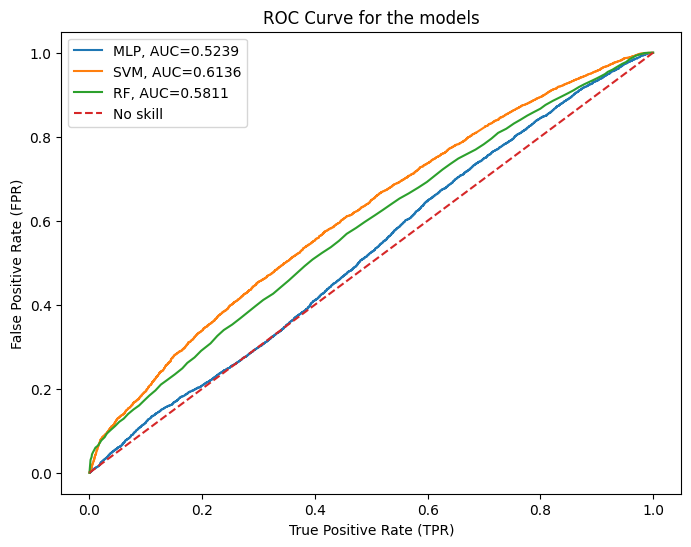

In [21]:
plt.figure(figsize=(8, 6))
plt.title("ROC Curve for the models")
# mlp
fpr, tpr, _ = roc_curve(y_test, mlp_probas[:, 1])
auc = round(roc_auc_score(y_test, mlp_probas[:, 1]), 4)
plt.plot(fpr, tpr, label="MLP, AUC="+str(auc))

# svm
fpr, tpr, _ = roc_curve(y_test, svm_probas[:, 1])
auc = round(roc_auc_score(y_test, svm_probas[:, 1]), 4)
plt.plot(fpr, tpr, label="SVM, AUC="+str(auc))

# RF
fpr, tpr, _ = roc_curve(y_test, rf_probas[:, 1])
auc = round(roc_auc_score(y_test, rf_probas[:, 1]), 4)
plt.plot(fpr, tpr, label="RF, AUC="+str(auc))

plt.plot(fpr, fpr, '--', label="No skill")
plt.legend()
plt.xlabel('True Positive Rate (TPR)')
plt.ylabel('False Positive Rate (FPR)')
plt.show()

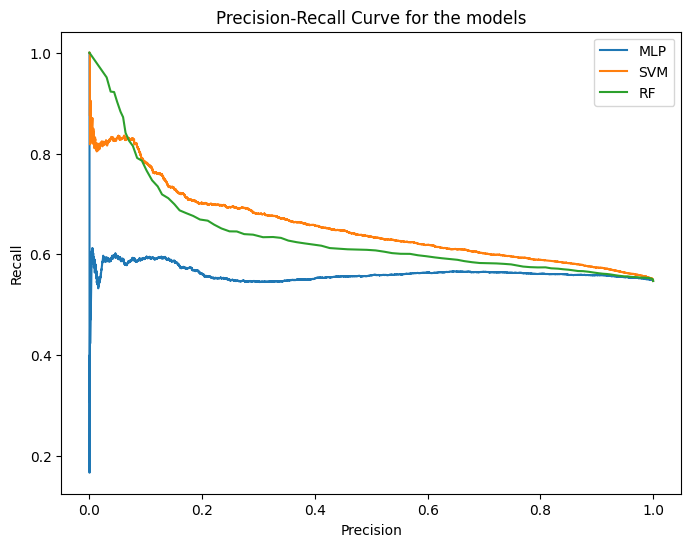

In [22]:
plt.figure(figsize=(8, 6))
plt.title("Precision-Recall Curve for the models")

# mlp
y, x, _ = precision_recall_curve(y_test, mlp_probas[:, 1])
plt.plot(x, y, label="MLP")

# svm
y, x, _ = precision_recall_curve(y_test, svm_probas[:, 1])
plt.plot(x, y, label="SVM")

# RF
y, x, _ = precision_recall_curve(y_test, rf_probas[:, 1])
plt.plot(x, y, label="RF")

plt.legend()
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()